# Idea

Test whether VespaG is learning destruction rather than effect using ProteinGym DMS data.

## Determine which protein to use out of ProteinGym 

- Filtered sequences for which 100% of the sequence has DMS annotation 
- Filtered sequences that have a sequence length that is smaller than 1000
- --> 91 remaining sequences
- generated VespaG predictions for these 
- now determine sequence with highest spearman correlation between VespaG predictions and DMS data 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

import sys 
sys.path.append('../vespag')

from parse.vep_scores import load_vespag_scores_from_folder, load_dms_scores_from_folder, load_fasta_file
from src.plotting import *
from src.amino_acid_groups import AA_GROUPS
from src.constants import GEMME_ALPHABET
from src.utils import *

In [15]:
# load the fasta file 
fasta_file = '/mnt/c/Users/nicol/Documents/proteingym/proteingym91.fasta'
sequences = load_fasta_file(fasta_file)
sequences.head()

id  \
0   A0A1I9GEU1_NEIME_Kennouche_2019   
1  A0A247D711_LISMN_Stadelmann_2021   
2            A4GRB6_PSEAI_Chen_2020   
3    AMFR_HUMAN_Tsuboyama_2023_4G3O   
4    ARGR_ECOLI_Tsuboyama_2023_1AOY   

                                            sequence  
0  FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...  
1  MNINDLIREIKNKDYTVKLSGTDSNSITQLIIRVNNDGNEYVISES...  
2  MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...  
3    YFQGQLNAMAHQIQEMFPQVPYHLVLQDLQLTRSVEITTDNILEGRI  
4  QEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKVSRMLTK...

In [16]:
# load all the vespag results 
vespag_path = '/mnt/c/Users/nicol/Documents/thesis/VespaG/output_proteingym91'
vespag_scores = load_vespag_scores_from_folder(vespag_path)
vespag_scores.head()

Loading VespaG scores: 100%|██████████| 91/91 [00:01<00:00, 47.49file/s]


residue mutation    vespag                               id
0      F1      F1A -4.765574  A0A1I9GEU1_NEIME_Kennouche_2019
1      F1      F1Y -3.040487  A0A1I9GEU1_NEIME_Kennouche_2019
2      F1      F1W -3.761433  A0A1I9GEU1_NEIME_Kennouche_2019
3      F1      F1V -2.995167  A0A1I9GEU1_NEIME_Kennouche_2019
4      F1      F1T -5.035661  A0A1I9GEU1_NEIME_Kennouche_2019

In [17]:
# load the DMS results
dms_path = '/mnt/c/Users/nicol/Documents/proteingym/DMS_ProteinGym_substitutions/DMS_ProteinGym_substitutions'
dms_scores = load_dms_scores_from_folder(dms_path)
# drop the mutated sequence and the DMS_score_bin and DMS_bin_score 
dms_scores = dms_scores.drop(columns=['mutated_sequence', 'DMS_score_bin', 'DMS_bin_score'])
# rename mutant to mutation
dms_scores = dms_scores.rename(columns={'mutant': 'mutation', 'DMS_score': 'dms_score'})
dms_scores.head()

Loading DMS scores: 100%|██████████| 217/217 [00:17<00:00, 12.21file/s]


mutation  dms_score                               id
0    I291A   0.030269  A0A140D2T1_ZIKV_Sourisseau_2019
1    I291Y   0.048604  A0A140D2T1_ZIKV_Sourisseau_2019
2    I291W   0.093642  A0A140D2T1_ZIKV_Sourisseau_2019
3    I291V   0.626747  A0A140D2T1_ZIKV_Sourisseau_2019
4    I291T   1.762066  A0A140D2T1_ZIKV_Sourisseau_2019

In [18]:
# combine the data based on the id and mutant
combined_scores = vespag_scores.merge(dms_scores, on=['id', 'mutation'])
combined_scores = combined_scores.merge(sequences, on='id')
combined_scores['sequence_length'] = combined_scores['sequence'].apply(len)
print(f"{vespag_scores.shape[0]} VespaG scores, {dms_scores.shape[0]} DMS scores, {combined_scores.shape[0]} combined scores")
combined_scores.head()

216866 VespaG scores, 2465767 DMS scores, 201928 combined scores


residue mutation    vespag                               id  dms_score  \
0      F1      F1Y -3.040487  A0A1I9GEU1_NEIME_Kennouche_2019     -2.373   
1      F1      F1V -2.995167  A0A1I9GEU1_NEIME_Kennouche_2019      1.299   
2      F1      F1S -5.042022  A0A1I9GEU1_NEIME_Kennouche_2019     -0.127   
3      F1      F1L -2.476698  A0A1I9GEU1_NEIME_Kennouche_2019     -0.678   
4      F1      F1I -2.955544  A0A1I9GEU1_NEIME_Kennouche_2019     -3.598   

                                            sequence  sequence_length  
0  FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...              161  
1  FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...              161  
2  FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...              161  
3  FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...              161  
4  FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...              161

In [19]:
# for each id, calculate the spearman correlation between the VespaG and DMS scores
correlations = []
for id, group in combined_scores.groupby('id'):
    spearman = group[['vespag', 'dms_score']].corr(method='spearman').iloc[0, 1]
    correlations.append({'id': id, 'spearman': spearman})
correlations = pd.DataFrame(correlations)
# order by the spearman correlation
correlations = correlations.sort_values('spearman', ascending=False)
correlations = correlations.merge(combined_scores[['id', 'sequence_length', 'sequence']].drop_duplicates(), on='id')
print(correlations.shape)
correlations.head()

(91, 4)


id  spearman  sequence_length  \
0             A4GRB6_PSEAI_Chen_2020  0.706617              266   
1    TCRG1_MOUSE_Tsuboyama_2023_1E0L  0.682527               37   
2    SQSTM_MOUSE_Tsuboyama_2023_2RRU  0.668104               40   
3  CP2C9_HUMAN_Amorosi_2021_activity  0.666448              490   
4               PHOT_CHLRE_Chen_2023  0.652427              118   

                                            sequence  
0  MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...  
1              GATAVSEWTEYKTADGKTYYYNNRTLESTWEKPQELK  
2           RLIESLSQMLSMGFSDEGGWLTRLLQTKNYDIGAALDTIQ  
3  MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...  
4  AGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQ...

In [39]:
correlations.spearman.mean()

0.4739985629883288

In [40]:
correlations.tail()

id  spearman  sequence_length  \
86         SYUA_HUMAN_Newberry_2020  0.224380              140   
87    SPA_STAAU_Tsuboyama_2023_1LP1  0.199884               55   
88            ENVZ_ECOLI_Ghose_2023  0.174989               60   
89    RAD_ANTMA_Tsuboyama_2023_2CJJ  0.122213               54   
90  A0A1I9GEU1_NEIME_Kennouche_2019  0.032986              161   

                                             sequence   A  C  D   E  F   G  H  \
86  MDVYMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLFVGSKTKE...  19  0  6  18  4  18  1   
87  KFNKELSVAGREIVTLPNLNDPQKKAFIFSLWDDPSQSANLLAEAK...   7  0  4   3  3   1  0   
88  LADDRTLLMAGVSHDLRTPLTRIRLATEMMSEQDGYLAESINKDIE...   5  1  6   6  1   2  1   
89  PWSAKENKAFERALAVYDKDTPDRWANVARAVEGRTPEEVKKHYEI...   7  0  4   7  1   1  1   
90  FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...  23  2  8   6  2  10  2   

     I   K   L  M  N  P  Q  R   S   T   V  W  Y  
86   2  15   4  4  3  5  6  0   4  10  19  0  2  
87   2   7   7  0  5  4  3  1   4   1   2  1  0  
88   6   1   8  3  2  1  2  5   3   4   1  0  2  
89   3   6   2  0  2  3  0  4   1   2   5  2  3  
90  10  11  10  2  9  4  7  4  15  14  14  3  5

In [20]:
# show all columns of a pandas frame 
pd.set_option('display.max_columns', None)

In [21]:
# for each mutated sequence, determine the count of the characters in the sequence and make a new dataframe out of the data 
sequence_counts = []
for id, group in combined_scores.groupby('id'):
    sequence = group['sequence'].iloc[0]
    counts = {aa: sequence.count(aa) for aa in GEMME_ALPHABET}
    counts['id'] = id
    sequence_counts.append(counts)
sequence_counts = pd.DataFrame(sequence_counts)
correlations = correlations.merge(sequence_counts, on='id')
correlations.head()

id  spearman  sequence_length  \
0             A4GRB6_PSEAI_Chen_2020  0.706617              266   
1    TCRG1_MOUSE_Tsuboyama_2023_1E0L  0.682527               37   
2    SQSTM_MOUSE_Tsuboyama_2023_2RRU  0.668104               40   
3  CP2C9_HUMAN_Amorosi_2021_activity  0.666448              490   
4               PHOT_CHLRE_Chen_2023  0.652427              118   

                                            sequence   A   C   D   E   F   G  \
0  MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...  29   1  14  16   7  23   
1              GATAVSEWTEYKTADGKTYYYNNRTLESTWEKPQELK   3   0   1   5   0   2   
2           RLIESLSQMLSMGFSDEGGWLTRLLQTKNYDIGAALDTIQ   2   0   3   2   1   4   
3  MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...  18  13  21  32  32  28   
4  AGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQ...  10   2   8   6   5  12   

    H   I   K   L   M   N   P   Q   R   S   T   V  W   Y  
0   9  15   6  27   2   7  14   6  11  24  16  26  3  10  
1   0   0   4   2   0   2   1   1   1   2   6   1  2   4  
2   0   3   1   7   2   1   0   3   2   4   3   0  1   1  
3  12  34  35  58  14  26  31  14  21  32  24  30  3  12  
4   2   3   9  10   1   3   7   3   6   4  10  12  1   4

In [22]:
correlations.sort_values(['spearman'], ascending=False).head()

id  spearman  sequence_length  \
0             A4GRB6_PSEAI_Chen_2020  0.706617              266   
1    TCRG1_MOUSE_Tsuboyama_2023_1E0L  0.682527               37   
2    SQSTM_MOUSE_Tsuboyama_2023_2RRU  0.668104               40   
3  CP2C9_HUMAN_Amorosi_2021_activity  0.666448              490   
4               PHOT_CHLRE_Chen_2023  0.652427              118   

                                            sequence   A   C   D   E   F   G  \
0  MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...  29   1  14  16   7  23   
1              GATAVSEWTEYKTADGKTYYYNNRTLESTWEKPQELK   3   0   1   5   0   2   
2           RLIESLSQMLSMGFSDEGGWLTRLLQTKNYDIGAALDTIQ   2   0   3   2   1   4   
3  MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...  18  13  21  32  32  28   
4  AGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQ...  10   2   8   6   5  12   

    H   I   K   L   M   N   P   Q   R   S   T   V  W   Y  
0   9  15   6  27   2   7  14   6  11  24  16  26  3  10  
1   0   0   4   2   0   2   1   1   1   2   6   1  2   4  
2   0   3   1   7   2   1   0   3   2   4   3   0  1   1  
3  12  34  35  58  14  26  31  14  21  32  24  30  3  12  
4   2   3   9  10   1   3   7   3   6   4  10  12  1   4

In [23]:
correlations.sort_values(['C', 'spearman'], ascending=False).head()

id  spearman  sequence_length  \
11              PRKN_HUMAN_Clausen_2023  0.637030              465   
3     CP2C9_HUMAN_Amorosi_2021_activity  0.666448              490   
44                R1AB_SARS2_Flynn_2022  0.487634              306   
31              PTEN_HUMAN_Mighell_2018  0.549912              403   
35  P53_HUMAN_Giacomelli_2018_WT_Nutlin  0.531922              393   

                                             sequence   A   C   D   E   F   G  \
11  MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFA...  27  35  23  28  17  38   
3   MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...  18  13  21  32  32  28   
44  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...  17  12  17   9  17  26   
31  MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...  17  10  33  29  25  15   
35  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...  24  10  20  30  11  23   

     H   I   K   L   M   N   P   Q   R   S   T   V  W   Y  
11  15  15  18  30   7  17  29  27  31  30  24  36  8  10  
3   12  34  35  58  14  26  31  14  21  32  24  30  3  12  
44   7  11  11  29  10  21  13  14  11  16  24  27  3  11  
31  13  20  34  27   9  23  23  13  20  22  21  24  2  23  
35  12   8  20  32  12  14  44  15  27  38  22  18  4   9

In [24]:
correlations_tidy = correlations.melt(id_vars=['id', 'spearman', 'sequence_length', 'sequence'], var_name='amino_acid', value_name='count')
correlations_tidy.head()

id  spearman  sequence_length  \
0             A4GRB6_PSEAI_Chen_2020  0.706617              266   
1    TCRG1_MOUSE_Tsuboyama_2023_1E0L  0.682527               37   
2    SQSTM_MOUSE_Tsuboyama_2023_2RRU  0.668104               40   
3  CP2C9_HUMAN_Amorosi_2021_activity  0.666448              490   
4               PHOT_CHLRE_Chen_2023  0.652427              118   

                                            sequence amino_acid  count  
0  MFKLLSKLLVYLTASIMAIASPLAFSVDSSGEYPTVSEIPVGEVRL...          A     29  
1              GATAVSEWTEYKTADGKTYYYNNRTLESTWEKPQELK          A      3  
2           RLIESLSQMLSMGFSDEGGWLTRLLQTKNYDIGAALDTIQ          A      2  
3  MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...          A     18  
4  AGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQ...          A     10

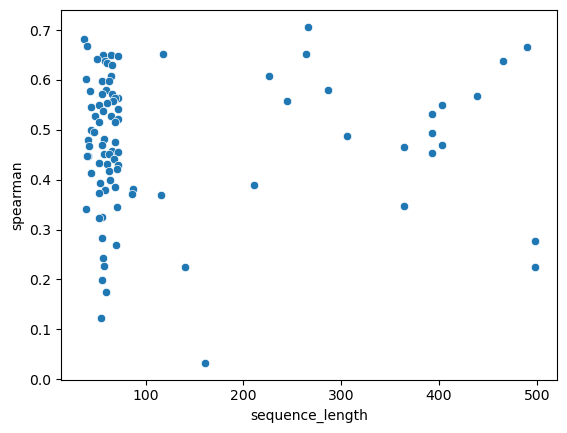

In [25]:
sns.scatterplot(data=correlations, x='sequence_length', y='spearman')
plt.show()

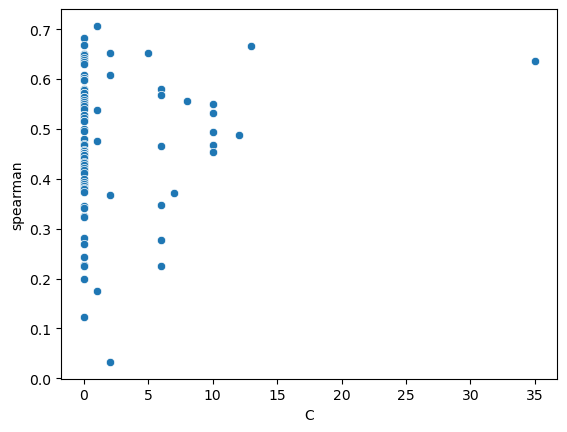

In [26]:
# scatterplot with the count of C vs the spearman correlation 
sns.scatterplot(data=correlations, x='C', y='spearman')
plt.show()

In [27]:
import plotly.express as px

# Create an interactive scatter plot
fig = px.scatter(
    correlations_tidy, 
    x='count', 
    y='spearman', 
    color='amino_acid', 
    hover_data=['amino_acid'],  # Show amino acid details on hover
    title='Interactive Scatterplot of Count vs Spearman Correlation',
    width=800,  
    height=800
)

# Show the interactive plot
fig.show()


## Select PRKN_HUMAN_Clausen_2023	

In [28]:
DMS_ID = 'PRKN_HUMAN_Clausen_2023'

In [29]:
sequence = correlations.query(f"id == '{DMS_ID}'")['sequence'].iloc[0]
sequence

'MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFAGKELRNDWTVQNCDLDQQSIVHIVQRPWRKGQEMNATGGDDPRNAAGGCEREPQSLTRVDLSSSVLPGDSVGLAVILHTDSRKDSPPAGSPAGRSIYNSFYVYCKGPCQRVQPGKLRVQCSTCRQATLTLTQGPSCWDDVLIPNRMSGECQSPHCPGTSAEFFFKCGAHPTSDKETSVALHLIATNSRNITCITCTDVRSPVLVFQCNSRHVICLDCFHLYCVTRLNDRQFVHDPQLGYSLPCVAGCPNSLIKELHHFRILGEEQYNRYQQYGAEECVLQMGGVLCPRPGCGAGLLPEPDQRKVTCEGGNGLGCGFAFCRECKEAYHEGECSAVFEASGTTTQAYRVDERAAEQARWEAASKETIKKTTKPCPRCHVPVEKNGGCMHMKCPQPQCRLEWCWNCGCEWNRVCMGDHWFDV'

In [30]:
id_vespag_scores = vespag_scores.query(f"id == '{DMS_ID}'").copy()
# invert the vespag score to get the mutation effect
id_vespag_scores['mutation_effect'] = - id_vespag_scores['vespag']
# normalize the mutation effect into [0,1]
id_vespag_scores['mutation_effect_normalized'] = (id_vespag_scores['mutation_effect'] - id_vespag_scores['mutation_effect'].min()) / (id_vespag_scores['mutation_effect'].max() - id_vespag_scores['mutation_effect'].min())
# extract residue_index 
id_vespag_scores['residue_index'] = id_vespag_scores['residue'].str[1:].astype(int)
# extract the wildtype residue
id_vespag_scores['wildtype'] = id_vespag_scores['residue'].str[0]
# extract the mutant residue
id_vespag_scores['mutant'] = id_vespag_scores['mutation'].str[-1]

In [31]:
id_dms_data = dms_scores.query(f"id == '{DMS_ID}'").copy()
id_dms_data['wildtype'] = id_dms_data['mutation'].str[0]
id_dms_data['mutant'] = id_dms_data['mutation'].str[-1]
id_dms_data['residue_index'] = id_dms_data['mutation'].str[1:-1].astype(int)

DMS Data is only available for a subsequence of the sequence

In [32]:
id_dms_data.dms_score.describe()

count    8756.000000
mean        0.693455
std         0.394270
min        -0.048093
25%         0.405989
50%         0.874295
75%         0.986538
max         1.390207
Name: dms_score, dtype: float64

- --> High DMS values --> stable or neutral effect on disrupting protein stability --> low mutational effect
- --> Medium DMS values --> medium mutational effect 
- --> Low DMS values --> destabilizing effect on protein structural stability --> strong mutational effect

In [41]:
id_dms_data['dms_mutation_effect'] = - id_dms_data['dms_score']
id_dms_data['dms_mutation_effect_normalized'] = (id_dms_data['dms_mutation_effect'] - id_dms_data['dms_mutation_effect'].min()) / (id_dms_data['dms_mutation_effect'].max() - id_dms_data['dms_mutation_effect'].min())

In [46]:
id_dms_data.shape[0] / id_vespag_scores.shape[0]

0.9910582908885116

In [42]:
# combine the data 
df = pd.merge(id_vespag_scores, id_dms_data.drop(columns=['wildtype', 'mutant', 'residue_index']), on=['id', 'mutation'], how='inner')
df.head()

residue mutation    vespag                       id  mutation_effect  \
0      M1      M1L -3.714597  PRKN_HUMAN_Clausen_2023         3.714597   
1      M1      M1I -4.026242  PRKN_HUMAN_Clausen_2023         4.026242   
2      I2      I2N -2.762721  PRKN_HUMAN_Clausen_2023         2.762721   
3      I2      I2Y -3.670464  PRKN_HUMAN_Clausen_2023         3.670464   
4      I2      I2W -3.855647  PRKN_HUMAN_Clausen_2023         3.855647   

   mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
0                    0.446130              1        M      L   0.906824   
1                    0.485391              1        M      I   0.865927   
2                    0.326213              2        I      N   1.087445   
3                    0.440570              2        I      Y   0.968744   
4                    0.463900              2        I      W   0.855693   

   dms_mutation_effect  dms_mutation_effect_normalized  
0            -0.906824                        0.336080  
1            -0.865927                        0.364514  
2            -1.087445                        0.210500  
3            -0.968744                        0.293029  
4            -0.855693                        0.371629

In [43]:
# calculate the correlation between the two scores
df[['mutation_effect_normalized', 'dms_mutation_effect_normalized']].corr()

mutation_effect_normalized  \
mutation_effect_normalized                        1.000000   
dms_mutation_effect_normalized                    0.680202   

                                dms_mutation_effect_normalized  
mutation_effect_normalized                            0.680202  
dms_mutation_effect_normalized                        1.000000

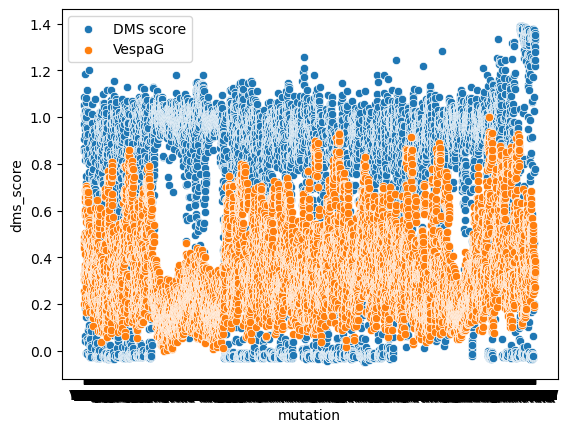

In [47]:
# scatterplot of the mutation effect and the dms score
sns.scatterplot(data=df, x='mutation', y='dms_score', label='DMS score')
sns.scatterplot(data=df, x='mutation', y='mutation_effect_normalized', label='VespaG')
plt.legend()
plt.show()

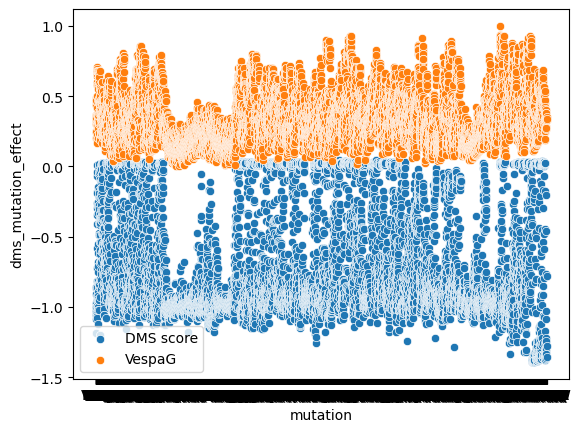

In [48]:
# scatterplot of the mutation effect and the dms score
sns.scatterplot(data=df, x='mutation', y='dms_mutation_effect', label='DMS score')
sns.scatterplot(data=df, x='mutation', y='mutation_effect_normalized', label='VespaG')
plt.legend()
plt.show()

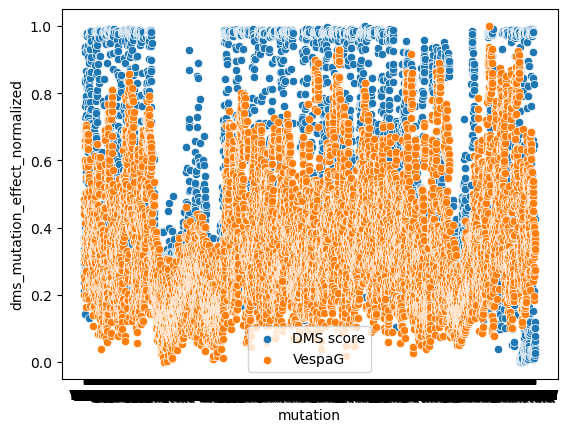

In [49]:
# scatterplot of the mutation effect and the dms score
sns.scatterplot(data=df, x='mutation', y='dms_mutation_effect_normalized', label='DMS score')
sns.scatterplot(data=df, x='mutation', y='mutation_effect_normalized', label='VespaG')
plt.legend()
plt.show()

# According to previous analysis:

- Q has a tendency to lead to low mutational effects

In [50]:
df.head()

residue mutation    vespag                       id  mutation_effect  \
0      M1      M1L -3.714597  PRKN_HUMAN_Clausen_2023         3.714597   
1      M1      M1I -4.026242  PRKN_HUMAN_Clausen_2023         4.026242   
2      I2      I2N -2.762721  PRKN_HUMAN_Clausen_2023         2.762721   
3      I2      I2Y -3.670464  PRKN_HUMAN_Clausen_2023         3.670464   
4      I2      I2W -3.855647  PRKN_HUMAN_Clausen_2023         3.855647   

   mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
0                    0.446130              1        M      L   0.906824   
1                    0.485391              1        M      I   0.865927   
2                    0.326213              2        I      N   1.087445   
3                    0.440570              2        I      Y   0.968744   
4                    0.463900              2        I      W   0.855693   

   dms_mutation_effect  dms_mutation_effect_normalized  
0            -0.906824                        0.336080  
1            -0.865927                        0.364514  
2            -1.087445                        0.210500  
3            -0.968744                        0.293029  
4            -0.855693                        0.371629

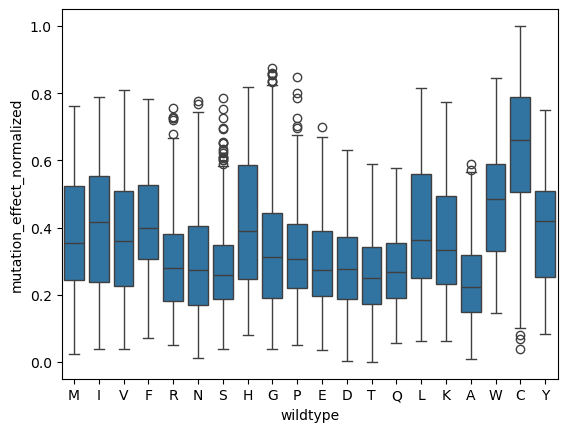

In [51]:
# show the distribution of the normalized vespag scores with respect to each wildtype residue
sns.boxplot(data=df, x='wildtype', y='mutation_effect_normalized')
plt.show()

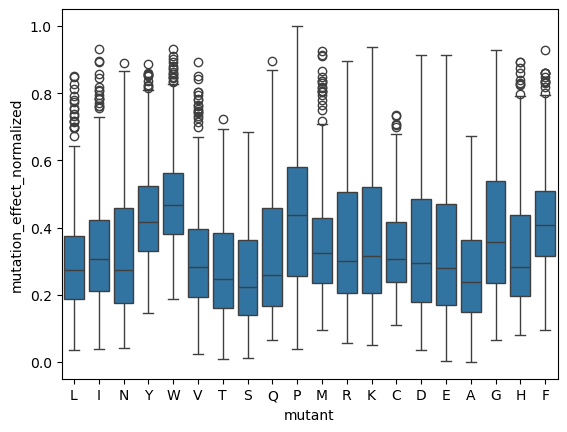

In [52]:
sns.boxplot(data=df, x='mutant', y='mutation_effect_normalized')
plt.show()

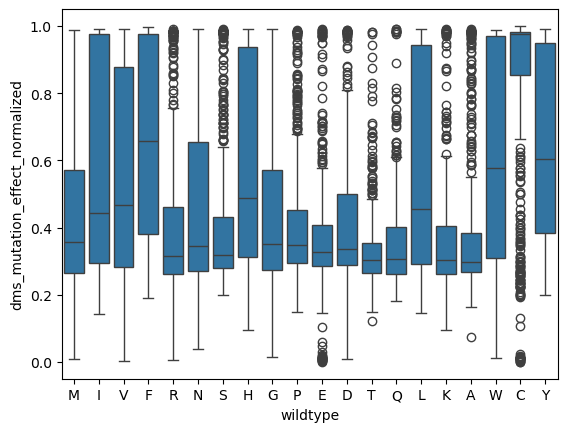

In [53]:
# and now for dms scores 
sns.boxplot(data=df, x='wildtype', y='dms_mutation_effect_normalized')
plt.show()

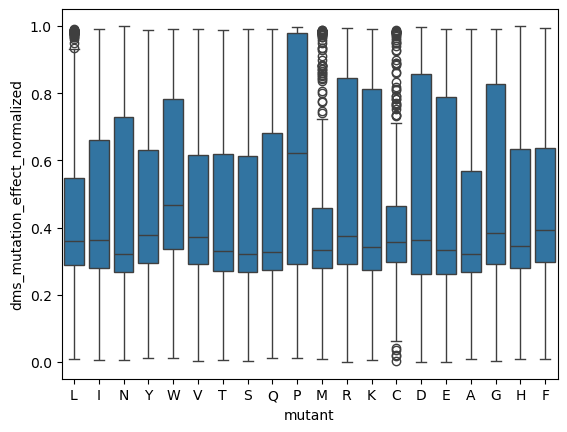

In [54]:
# and now for dms scores 
sns.boxplot(data=df, x='mutant', y='dms_mutation_effect_normalized')
plt.show()

In [55]:
sequence.count('Q')

27

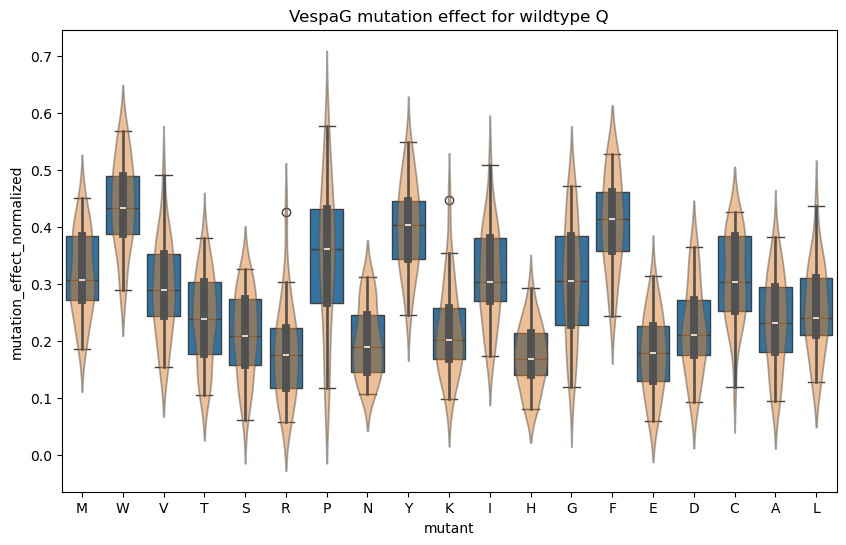

In [69]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.query("wildtype == 'Q'"), x='mutant', y='mutation_effect_normalized', zorder=0)
sns.violinplot(data=df.query("wildtype == 'Q'"), x='mutant', y='mutation_effect_normalized', alpha=0.5, zorder=2)
plt.title('VespaG mutation effect for wildtype Q')
plt.show()

In [ ]:
mean_mutation_effect = df.query("wildtype == 'Q'")['mutation_effect_normalized'].mean().round(4)
sem_mutation_effect = df.query("wildtype == 'Q'")['mutation_effect_normalized'].sem().round(4)
print(mean_mutation_effect, "+-", sem_mutation_effect)

0.2755 +- 0.005


In [73]:
mean_mutation_effect = df.query("(wildtype == 'Q') & (mutant=='P')")['mutation_effect_normalized'].mean().round(4)
sem_mutation_effect = df.query("(wildtype == 'Q') & (mutant=='P')")['mutation_effect_normalized'].sem().round(4)
print(mean_mutation_effect, "+-", sem_mutation_effect)

0.3485 +- 0.0248


In [106]:
df.query("(wildtype == 'Q') & (residue_index == 34)").sort_values('dms_mutation_effect_normalized', ascending=False)

residue mutation    vespag                       id  mutation_effect  \
614     Q34     Q34P -3.995911  PRKN_HUMAN_Clausen_2023         3.995911   
623     Q34     Q34D -2.583754  PRKN_HUMAN_Clausen_2023         2.583754   
620     Q34     Q34G -3.143052  PRKN_HUMAN_Clausen_2023         3.143052   
626     Q34     Q34K -2.677640  PRKN_HUMAN_Clausen_2023         2.677640   
615     Q34     Q34M -2.228083  PRKN_HUMAN_Clausen_2023         2.228083   
613     Q34     Q34R -2.341259  PRKN_HUMAN_Clausen_2023         2.341259   
617     Q34     Q34L -1.768861  PRKN_HUMAN_Clausen_2023         1.768861   
625     Q34     Q34A -1.935475  PRKN_HUMAN_Clausen_2023         1.935475   
612     Q34     Q34S -1.780686  PRKN_HUMAN_Clausen_2023         1.780686   
624     Q34     Q34C -2.147515  PRKN_HUMAN_Clausen_2023         2.147515   
609     Q34     Q34W -3.310750  PRKN_HUMAN_Clausen_2023         3.310750   
621     Q34     Q34F -2.804451  PRKN_HUMAN_Clausen_2023         2.804451   
608     Q34     Q34Y -2.924304  PRKN_HUMAN_Clausen_2023         2.924304   
611     Q34     Q34T -1.830912  PRKN_HUMAN_Clausen_2023         1.830912   
616     Q34     Q34N -2.091851  PRKN_HUMAN_Clausen_2023         2.091851   
619     Q34     Q34H -1.852958  PRKN_HUMAN_Clausen_2023         1.852958   
622     Q34     Q34E -2.160599  PRKN_HUMAN_Clausen_2023         2.160599   
610     Q34     Q34V -2.239706  PRKN_HUMAN_Clausen_2023         2.239706   
618     Q34     Q34I -2.276071  PRKN_HUMAN_Clausen_2023         2.276071   

     mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
614                    0.481570             34        Q      P  -0.025510   
623                    0.303666             34        Q      D   0.576026   
620                    0.374127             34        Q      G   0.698510   
626                    0.315494             34        Q      K   0.760398   
615                    0.258859             34        Q      M   0.862443   
613                    0.273117             34        Q      R   0.897076   
617                    0.201006             34        Q      L   0.905110   
625                    0.221996             34        Q      A   0.908423   
612                    0.202496             34        Q      S   0.975991   
624                    0.248709             34        Q      C   0.990552   
609                    0.395253             34        Q      W   1.003192   
621                    0.331470             34        Q      F   1.009226   
608                    0.346569             34        Q      Y   1.018192   
611                    0.208823             34        Q      T   1.019732   
616                    0.241696             34        Q      N   1.029234   
619                    0.211601             34        Q      H   1.047902   
622                    0.250357             34        Q      E   1.063489   
610                    0.260323             34        Q      V   1.069775   
618                    0.264905             34        Q      I   1.077739   

     dms_mutation_effect  dms_mutation_effect_normalized  
614             0.025510                        0.984299  
623            -0.576026                        0.566072  
620            -0.698510                        0.480913  
626            -0.760398                        0.437884  
615            -0.862443                        0.366936  
613            -0.897076                        0.342857  
617            -0.905110                        0.337271  
625            -0.908423                        0.334968  
612            -0.975991                        0.287990  
624            -0.990552                        0.277866  
609            -1.003192                        0.269078  
621            -1.009226                        0.264883  
608            -1.018192                        0.258649  
611            -1.019732                        0.257578  
616            -1.029234                        0.250972 

In [104]:
df.query("wildtype == 'Q'").sort_values('dms_mutation_effect_normalized', ascending=False).head(20)

residue mutation    vespag                       id  mutation_effect  \
5189    Q276    Q276P -3.431869  PRKN_HUMAN_Clausen_2023         3.431869   
2960    Q158    Q158P -3.125914  PRKN_HUMAN_Clausen_2023         3.125914   
2969    Q158    Q158D -2.660208  PRKN_HUMAN_Clausen_2023         2.660208   
614      Q34     Q34P -3.995911  PRKN_HUMAN_Clausen_2023         3.995911   
5949    Q316    Q316P -4.750457  PRKN_HUMAN_Clausen_2023         4.750457   
443      Q25     Q25P -3.125662  PRKN_HUMAN_Clausen_2023         3.125662   
3200    Q171    Q171P -3.651715  PRKN_HUMAN_Clausen_2023         3.651715   
3086    Q165    Q165P -3.909475  PRKN_HUMAN_Clausen_2023         3.909475   
5973    Q317    Q317P -4.562297  PRKN_HUMAN_Clausen_2023         4.562297   
8230    Q438    Q438P -3.231003  PRKN_HUMAN_Clausen_2023         3.231003   
447      Q25     Q25I -2.577616  PRKN_HUMAN_Clausen_2023         2.577616   
2967    Q158    Q158F -3.772382  PRKN_HUMAN_Clausen_2023         3.772382   
723      Q40     Q40P -3.136610  PRKN_HUMAN_Clausen_2023         3.136610   
455      Q25     Q25L -2.266463  PRKN_HUMAN_Clausen_2023         2.266463   
4749    Q252    Q252F -4.348021  PRKN_HUMAN_Clausen_2023         4.348021   
4744    Q252    Q252I -3.607099  PRKN_HUMAN_Clausen_2023         3.607099   
2955    Q158    Q158W -3.911896  PRKN_HUMAN_Clausen_2023         3.911896   
4740    Q252    Q252W -4.678771  PRKN_HUMAN_Clausen_2023         4.678771   
5858    Q311    Q311R -2.577908  PRKN_HUMAN_Clausen_2023         2.577908   
2961    Q158    Q158Y -3.688133  PRKN_HUMAN_Clausen_2023         3.688133   

      mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
5189                    0.410512            276        Q      P  -0.033841   
2960                    0.371968            158        Q      P  -0.032831   
2969                    0.313298            158        Q      D  -0.028473   
614                     0.481570             34        Q      P  -0.025510   
5949                    0.576628            316        Q      P  -0.024514   
443                     0.371936             25        Q      P  -0.022082   
3200                    0.438208            171        Q      P  -0.020518   
3086                    0.470681            165        Q      P  -0.020000   
5973                    0.552923            317        Q      P  -0.019971   
8230                    0.385207            438        Q      P  -0.014645   
447                     0.302893             25        Q      I   0.109198   
2967                    0.453410            158        Q      F   0.218687   
723                     0.373315             40        Q      P   0.233492   
455                     0.263694             25        Q      L   0.262538   
4749                    0.525929            252        Q      F   0.264709   
4744                    0.432588            252        Q      I   0.307647   
2955                    0.470986            158        Q      W   0.332464   
4740                    0.567597            252        Q      W   0.339995   
5858                    0.302930            311        Q      R   0.340021   
2961                    0.442796            158        Q      Y   0.346325   

      dms_mutation_effect  dms_mutation_effect_normalized  
5189             0.033841                        0.990091  
2960             0.032831                        0.989389  
2969             0.028473                        0.986359  
614              0.025510                        0.984299  
5949             0.024514                        0.983606  
443              0.022082                        0.981915  
3200             0.020518                        0.980828  
3086             0.020000                        0.980467  
5973             0.019971                        0.980448  
8230             0.014645                        0.976745  
447             -0.109198                        0.890641  
2967            -0.218687   

In [100]:
df.query("(wildtype == 'P') & (mutant=='L')").sort_values('residue_index', ascending=True).head()

residue mutation    vespag                       id  mutation_effect  \
237      P14     P14L -2.889889  PRKN_HUMAN_Clausen_2023         2.889889   
674      P37     P37L -2.381503  PRKN_HUMAN_Clausen_2023         2.381503   
1356     P73     P73L -1.957901  PRKN_HUMAN_Clausen_2023         1.957901   
1642     P88     P88L -1.126548  PRKN_HUMAN_Clausen_2023         1.126548   
1851     P99     P99L -1.477325  PRKN_HUMAN_Clausen_2023         1.477325   

      mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
237                     0.342233             14        P      L   0.076275   
674                     0.278187             37        P      L   0.804933   
1356                    0.224822             73        P      L   0.838157   
1642                    0.120088             88        P      L   1.008574   
1851                    0.164278             99        P      L   0.991658   

      dms_mutation_effect  dms_mutation_effect_normalized  
237             -0.076275                        0.913531  
674             -0.804933                        0.406921  
1356            -0.838157                        0.383821  
1642            -1.008574                        0.265336  
1851            -0.991658                        0.277097

check known variants

In [94]:
sequence.count('M')

7

In [75]:
df.query('mutation == "M434T"')

residue mutation    vespag                       id  mutation_effect  \
8153    M434    M434T -4.950922  PRKN_HUMAN_Clausen_2023         4.950922   

      mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
8153                    0.601882            434        M      T   1.165527   

      dms_mutation_effect  dms_mutation_effect_normalized  
8153            -1.165527                        0.156213

In [ ]:
vespag_scores['wildtype'] = vespag_scores['mutation'].str[0]
vespag_scores['mutant'] = vespag_scores['mutation'].str[-1]
vespag_scores['mutation_effect_normalized'] = (vespag_scores['vespag'] - vespag_scores['vespag'].min()) / (vespag_scores['vespag'].max() - vespag_scores['vespag'].min())

In [89]:
mean_mutation_effect = vespag_scores.query("wildtype == 'M'")['mutation_effect_normalized'].mean().round(4)
sem_mutation_effect = vespag_scores.query("wildtype == 'M'")['mutation_effect_normalized'].sem().round(4)
print(mean_mutation_effect, "+-", sem_mutation_effect)

0.6146 +- 0.002


In [91]:
mean_mutation_effect = vespag_scores.query("wildtype == 'M' & mutant=='T'")['mutation_effect_normalized'].mean().round(4)
sem_mutation_effect = vespag_scores.query("wildtype == 'M' & mutant=='T'")['mutation_effect_normalized'].sem().round(4)
print(mean_mutation_effect, "+-", sem_mutation_effect)

0.6653 +- 0.0066


In [83]:
mean_mutation_effect = df.query("wildtype == 'M'")['mutation_effect_normalized'].mean().round(4)
sem_mutation_effect = df.query("wildtype == 'M'")['mutation_effect_normalized'].sem().round(4)
print(mean_mutation_effect, "+-", sem_mutation_effect)

0.3687 +- 0.0177


In [82]:
mean_mutation_effect = df.query("(wildtype == 'M') & (mutant=='T')")['mutation_effect_normalized'].mean().round(4)
sem_mutation_effect = df.query("(wildtype == 'M') & (mutant=='T')")['mutation_effect_normalized'].sem().round(4)
print(mean_mutation_effect, "+-", sem_mutation_effect)

0.3128 +- 0.0787


In [76]:
df.query('mutation == "P437L"')

residue mutation    vespag                       id  mutation_effect  \
8213    P437    P437L -2.406712  PRKN_HUMAN_Clausen_2023         2.406712   

      mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
8213                    0.281363            437        P      L   0.870019   

      dms_mutation_effect  dms_mutation_effect_normalized  
8213            -0.870019                        0.361669

In [77]:
df.query('mutation == "R33Q"')

residue mutation    vespag                       id  mutation_effect  \
591     R33     R33Q -1.713302  PRKN_HUMAN_Clausen_2023         1.713302   

     mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
591                    0.194007             33        R      Q   0.838149   

     dms_mutation_effect  dms_mutation_effect_normalized  
591            -0.838149                        0.383827

In [78]:
df.query('mutation == "G284R"')

residue mutation    vespag                       id  mutation_effect  \
5345    G284    G284R -3.708725  PRKN_HUMAN_Clausen_2023         3.708725   

      mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
5345                     0.44539            284        G      R   0.437947   

      dms_mutation_effect  dms_mutation_effect_normalized  
5345            -0.437947                        0.662073

In [79]:
df.query('mutation == "K161N"')

residue mutation   vespag                       id  mutation_effect  \
3011    K161    K161N -4.09054  PRKN_HUMAN_Clausen_2023          4.09054   

      mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
3011                    0.493491            161        K      N    0.93758   

      dms_mutation_effect  dms_mutation_effect_normalized  
3011             -0.93758                        0.314696

In [80]:
df.query('mutation == "T415N"')

residue mutation    vespag                       id  mutation_effect  \
7795    T415    T415N -3.918059  PRKN_HUMAN_Clausen_2023         3.918059   

      mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
7795                    0.471762            415        T      N   1.016868   

      dms_mutation_effect  dms_mutation_effect_normalized  
7795            -1.016868                         0.25957

In [81]:
df.query('mutation == "G430D"')

residue mutation    vespag                       id  mutation_effect  \
8085    G430    G430D -5.220134  PRKN_HUMAN_Clausen_2023         5.220134   

      mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
8085                    0.635798            430        G      D   1.001505   

      dms_mutation_effect  dms_mutation_effect_normalized  
8085            -1.001505                        0.270251

In [147]:
df.query('residue == "M192"').sort_values('mutation_effect_normalized', ascending=False)

residue mutation    vespag                       id  mutation_effect  \
3612    M192    M192D -4.616759  PRKN_HUMAN_Clausen_2023         4.616759   
3614    M192    M192K -4.554283  PRKN_HUMAN_Clausen_2023         4.554283   
3597    M192    M192N -4.508933  PRKN_HUMAN_Clausen_2023         4.508933   
3608    M192    M192H -4.500296  PRKN_HUMAN_Clausen_2023         4.500296   
3604    M192    M192P -4.491835  PRKN_HUMAN_Clausen_2023         4.491835   
3611    M192    M192E -4.491436  PRKN_HUMAN_Clausen_2023         4.491436   
3598    M192    M192W -4.457598  PRKN_HUMAN_Clausen_2023         4.457598   
3602    M192    M192R -4.443195  PRKN_HUMAN_Clausen_2023         4.443195   
3609    M192    M192G -4.438887  PRKN_HUMAN_Clausen_2023         4.438887   
3603    M192    M192Q -4.412824  PRKN_HUMAN_Clausen_2023         4.412824   
3605    M192    M192Y -4.302820  PRKN_HUMAN_Clausen_2023         4.302820   
3610    M192    M192F -3.707031  PRKN_HUMAN_Clausen_2023         3.707031   
3601    M192    M192S -3.540652  PRKN_HUMAN_Clausen_2023         3.540652   
3600    M192    M192T -3.112456  PRKN_HUMAN_Clausen_2023         3.112456   
3613    M192    M192A -3.041415  PRKN_HUMAN_Clausen_2023         3.041415   
3606    M192    M192L -1.400254  PRKN_HUMAN_Clausen_2023         1.400254   
3607    M192    M192I -1.175965  PRKN_HUMAN_Clausen_2023         1.175965   
3599    M192    M192V -1.038253  PRKN_HUMAN_Clausen_2023         1.038253   

      mutation_effect_normalized  residue_index wildtype mutant  dms_score  \
3612                    0.559786            192        M      D  -0.032686   
3614                    0.551918            192        M      K   0.691951   
3597                    0.546207            192        M      N   0.174168   
3608                    0.545119            192        M      H   0.431567   
3604                    0.544054            192        M      P  -0.009223   
3611                    0.544004            192        M      E  -0.000999   
3598                    0.539742            192        M      W   0.048561   
3602                    0.537928            192        M      R   0.653018   
3609                    0.537386            192        M      G   0.367239   
3603                    0.534103            192        M      Q   0.558197   
3605                    0.520250            192        M      Y   0.221778   
3610                    0.445218            192        M      F   0.706564   
3601                    0.424265            192        M      S   0.542201   
3600                    0.370339            192        M      T   0.647613   
3613                    0.361392            192        M      A   0.635147   
3606                    0.154709            192        M      L   1.016324   
3607                    0.126463            192        M      I   1.015434   
3599                    0.109120            192        M      V   0.971946   

      dms_mutation_effect  dms_mutation_effect_normalized  
3612             0.032686                        0.989288  
3614            -0.691951                        0.485473  
3597            -0.174168                        0.845469  
3608            -0.431567                        0.666509  
3604             0.009223                        0.972975  
3611             0.000999                        0.967257  
3598            -0.048561                        0.932799  
3602            -0.653018                        0.512542  
3609            -0.367239                        0.711234  
3603            -0.558197                        0.578467  
3605            -0.221778                        0.812368  
3610            -0.706564                        0.475313  
3601            -0.542201                        0.589589  
3600            -0.647613                        0.516300  
3613            -0.635147                        0.524967  
3606            -1.016324                        0.259948  
3607            -1.015434             

In [137]:
df[df.mutation_effect_normalized - df.dms_mutation_effect_normalized > 0.4].sort_values('residue_index')

residue mutation    vespag                       id  mutation_effect  \
862      G47     G47M -6.811057  PRKN_HUMAN_Clausen_2023         6.811057   
1221     I66     I66Y -5.802716  PRKN_HUMAN_Clausen_2023         5.802716   
3020    K161    K161Y -5.828599  PRKN_HUMAN_Clausen_2023         5.828599   
3021    K161    K161I -5.074031  PRKN_HUMAN_Clausen_2023         5.074031   
3051    R163    R163M -5.555145  PRKN_HUMAN_Clausen_2023         5.555145   
3053    R163    R163V -5.284689  PRKN_HUMAN_Clausen_2023         5.284689   
3054    R163    R163W -5.947128  PRKN_HUMAN_Clausen_2023         5.947128   
3057    R163    R163Y -5.875543  PRKN_HUMAN_Clausen_2023         5.875543   
3058    R163    R163I -5.325191  PRKN_HUMAN_Clausen_2023         5.325191   
3061    R163    R163D -5.154490  PRKN_HUMAN_Clausen_2023         5.154490   
3063    R163    R163F -5.934590  PRKN_HUMAN_Clausen_2023         5.934590   
3064    R163    R163G -5.920361  PRKN_HUMAN_Clausen_2023         5.920361   
7643    S407    S407Y -6.140982  PRKN_HUMAN_Clausen_2023         6.140982   
7650    S407    S407K -5.676177  PRKN_HUMAN_Clausen_2023         5.676177   
7642    S407    S407W -6.397158  PRKN_HUMAN_Clausen_2023         6.397158   
7983    V425    V425Q -5.843801  PRKN_HUMAN_Clausen_2023         5.843801   
7986    V425    V425N -6.087472  PRKN_HUMAN_Clausen_2023         6.087472   
7990    V425    V425G -6.023070  PRKN_HUMAN_Clausen_2023         6.023070   
7992    V425    V425E -5.924745  PRKN_HUMAN_Clausen_2023         5.924745   
7993    V425    V425D -6.249059  PRKN_HUMAN_Clausen_2023         6.249059   
7997    E426    E426P -5.716182  PRKN_HUMAN_Clausen_2023         5.716182   
8023    K427    K427P -5.434044  PRKN_HUMAN_Clausen_2023         5.434044   
8024    K427    K427Y -4.298958  PRKN_HUMAN_Clausen_2023         4.298958   
8083    G430    G430A -4.316196  PRKN_HUMAN_Clausen_2023         4.316196   
8091    G430    G430F -7.006932  PRKN_HUMAN_Clausen_2023         7.006932   
8090    G430    G430K -6.299930  PRKN_HUMAN_Clausen_2023         6.299930   
8088    G430    G430H -5.743305  PRKN_HUMAN_Clausen_2023         5.743305   
8087    G430    G430L -6.314936  PRKN_HUMAN_Clausen_2023         6.314936   
8082    G430    G430M -6.631630  PRKN_HUMAN_Clausen_2023         6.631630   
8081    G430    G430P -6.715014  PRKN_HUMAN_Clausen_2023         6.715014   
8080    G430    G430N -5.190434  PRKN_HUMAN_Clausen_2023         5.190434   
8079    G430    G430T -5.001241  PRKN_HUMAN_Clausen_2023         5.001241   
8078    G430    G430W -7.119354  PRKN_HUMAN_Clausen_2023         7.119354   
8076    G430    G430Y -6.944448  PRKN_HUMAN_Clausen_2023         6.944448   
8074    G430    G430R -5.748282  PRKN_HUMAN_Clausen_2023         5.748282   
8073    G430    G430Q -5.660905  PRKN_HUMAN_Clausen_2023         5.660905   
8092    C431    C431N -5.903226  PRKN_HUMAN_Clausen_2023         5.903226   
8099    C431    C431P -6.258796  PRKN_HUMAN_Clausen_2023         6.258796   
8100    C431    C431Y -6.411006  PRKN_HUMAN_Clausen_2023         6.411006   
8105    C431    C431G -6.041215  PRKN_HUMAN_Clausen_2023         6.041215   
8153    M434    M434T -4.953298  PRKN_HUMAN_Clausen_2023         4.953298   
8477    C451    C451W -4.270008  PRKN_HUMAN_Clausen_2023         4.270008   
8489    C451    C451F -3.614712  PRKN_HUMAN_Clausen_2023         3.614712   
8473    C451    C451Y -3.644285  PRKN_HUMAN_Clausen_2023         3.644285   
8474    C451    C451P -5.205215  PRKN_HUMAN_Clausen_2023         5.205215   
8491    E452    E452W -3.763423  PRKN_HUMAN_Clausen_2023         3.763423   
8509    W453    W453M -3.750970  PRKN_HUMAN_Clausen_2023         3.750970   
8604    M458    M458P -4.278211  PRKN_HUMAN_Clausen_2023         4.278211   
8616    M458    M458C -3.588174  PRKN_HUMAN_Clausen_2023         3.588174   
8620    M458    M458G -3.913429  PRKN_HUMAN_Clausen_2023         3.913429   
8641    G459    G459F -4.570441  PRKN_HUMAN_Clausen_2023         4.570441   
8

When we mutate a Q to a C, we expect a change in the dms score because the structure of the protein will be affected. 

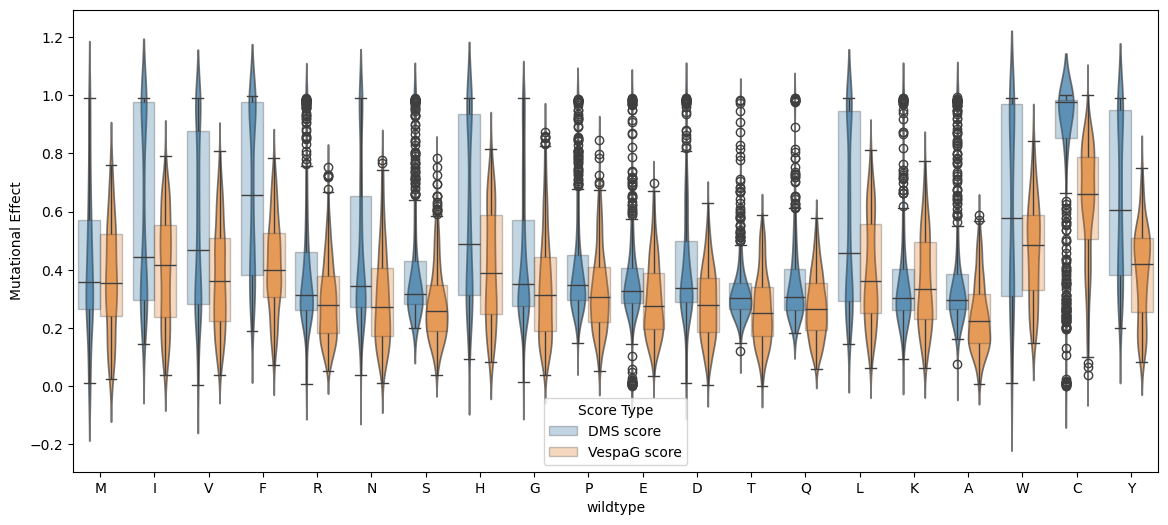

In [116]:
plt.figure(figsize=(14, 6))

# Create a new column to differentiate DMS and VespaG
df_melted = df.melt(id_vars=['wildtype'], 
                    value_vars=['dms_mutation_effect_normalized', 'mutation_effect_normalized'], 
                    var_name='score_type', 
                    value_name='mutational_effect')

# Rename values for better legend readability
df_melted['score_type'] = df_melted['score_type'].replace({
    'dms_mutation_effect_normalized': 'DMS score',
    'mutation_effect_normalized': 'VespaG score'
})

# Boxplot
sns.boxplot(data=df_melted, x='wildtype', y='mutational_effect', hue='score_type', 
            boxprops=dict(alpha=.3), dodge=True)

# Violin plot (slightly transparent)
sns.violinplot(data=df_melted, x='wildtype', y='mutational_effect', hue='score_type', 
               inner=None, alpha=0.7, dodge=True)

# Remove duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

plt.legend(unique_handles, unique_labels, title="Score Type")
plt.ylabel('Mutational Effect')
plt.show()

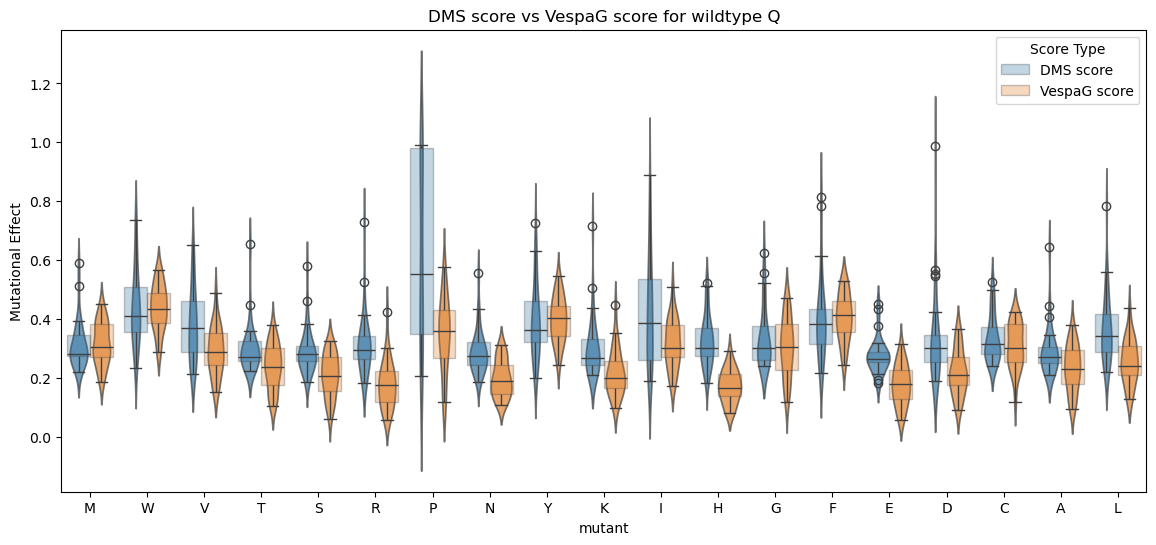

In [117]:
plt.figure(figsize=(14, 6))

# Create a new column to differentiate DMS and VespaG
df_melted = df.melt(id_vars=['wildtype', 'mutant'], 
                    value_vars=['dms_mutation_effect_normalized', 'mutation_effect_normalized'], 
                    var_name='score_type', 
                    value_name='mutational_effect')

df_melted['score_type'] = df_melted['score_type'].replace({
    'dms_mutation_effect_normalized': 'DMS score',
    'mutation_effect_normalized': 'VespaG score'
})

plotting_data = df_melted.query("wildtype == 'Q'")

# Boxplot
sns.boxplot(data=plotting_data, x='mutant', y='mutational_effect', hue='score_type', 
            boxprops=dict(alpha=.3), dodge=True)

# Violin plot (slightly transparent)
sns.violinplot(data=plotting_data, x='mutant', y='mutational_effect', hue='score_type', 
               inner=None, alpha=0.7, dodge=True)

# Remove duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

plt.legend(unique_handles, unique_labels, title="Score Type")
plt.ylabel('Mutational Effect')
plt.title('DMS score vs VespaG score for wildtype Q')
plt.show()

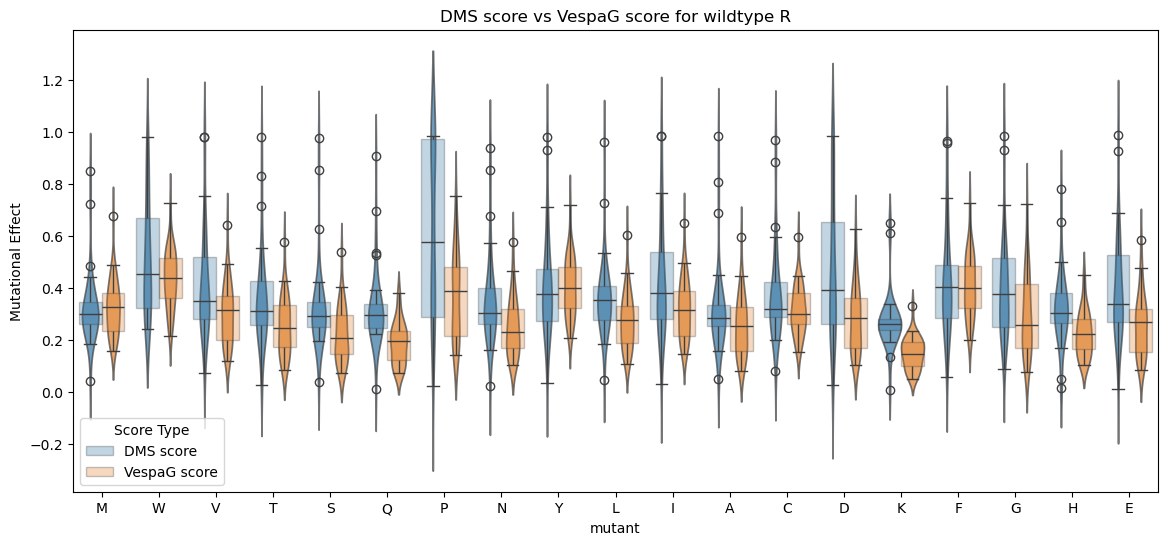

In [118]:
plt.figure(figsize=(14, 6))

plotting_data = df_melted.query("wildtype == 'R'")

# Boxplot
sns.boxplot(data=plotting_data, x='mutant', y='mutational_effect', hue='score_type', 
            boxprops=dict(alpha=.3), dodge=True)

# Violin plot (slightly transparent)
sns.violinplot(data=plotting_data, x='mutant', y='mutational_effect', hue='score_type', 
               inner=None, alpha=0.7, dodge=True)

# Remove duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

plt.legend(unique_handles, unique_labels, title="Score Type")
plt.ylabel('Mutational Effect')
plt.title('DMS score vs VespaG score for wildtype R')
plt.show()

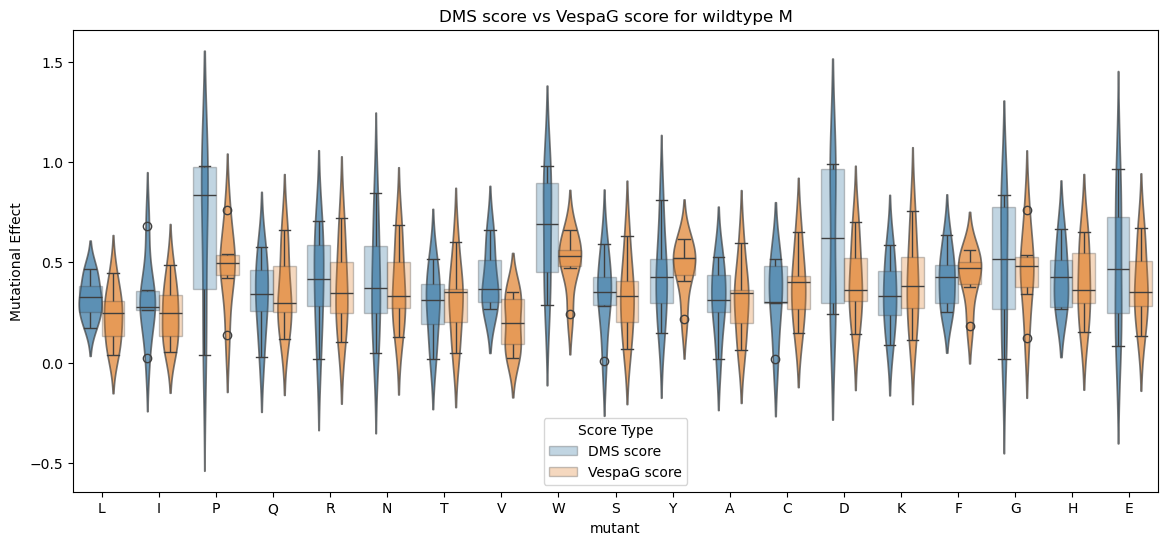

In [134]:
plt.figure(figsize=(14, 6))

plotting_data = df_melted.query("wildtype == 'M'")

# Boxplot
sns.boxplot(data=plotting_data, x='mutant', y='mutational_effect', hue='score_type', 
            boxprops=dict(alpha=.3), dodge=True)

# Violin plot (slightly transparent)
sns.violinplot(data=plotting_data, x='mutant', y='mutational_effect', hue='score_type', 
               inner=None, alpha=0.7, dodge=True)

# Remove duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

plt.legend(unique_handles, unique_labels, title="Score Type")
plt.ylabel('Mutational Effect')
plt.title('DMS score vs VespaG score for wildtype M')
plt.show()

<Axes: xlabel='mutant', ylabel='dms_mutation_effect_normalized'>

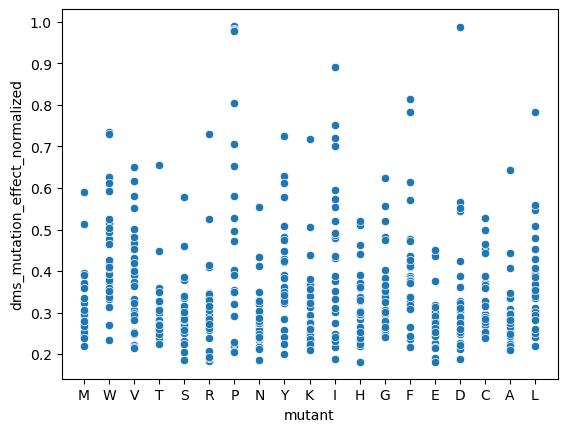

In [119]:
sns.scatterplot(data=df.query("wildtype == 'Q'"), x='mutant', y='dms_mutation_effect_normalized')

<Axes: xlabel='mutant', ylabel='mutation_effect_normalized'>

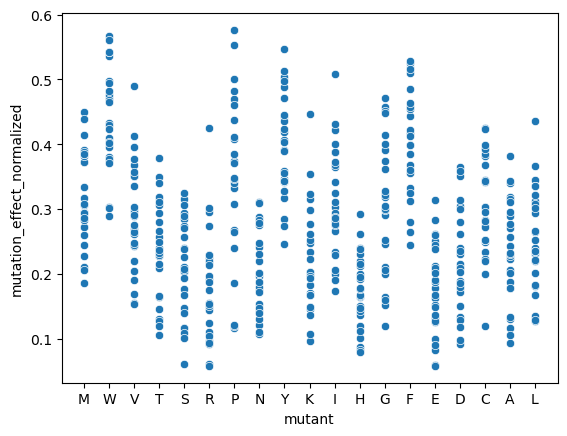

In [120]:
sns.scatterplot(data=df.query("wildtype == 'Q'"), x='mutant', y='mutation_effect_normalized')

<Axes: xlabel='mutant', ylabel='dms_mutation_effect_normalized'>

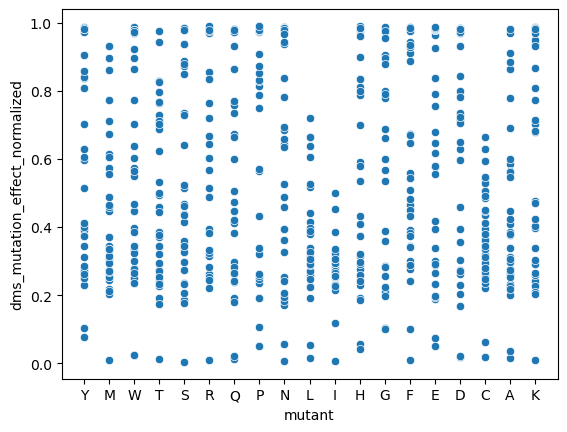

In [121]:
sns.scatterplot(data=df.query("wildtype == 'V'"), x='mutant', y='dms_mutation_effect_normalized')

In [122]:
df.query('wildtype == "Q" and mutant == "C"').shape

(27, 12)

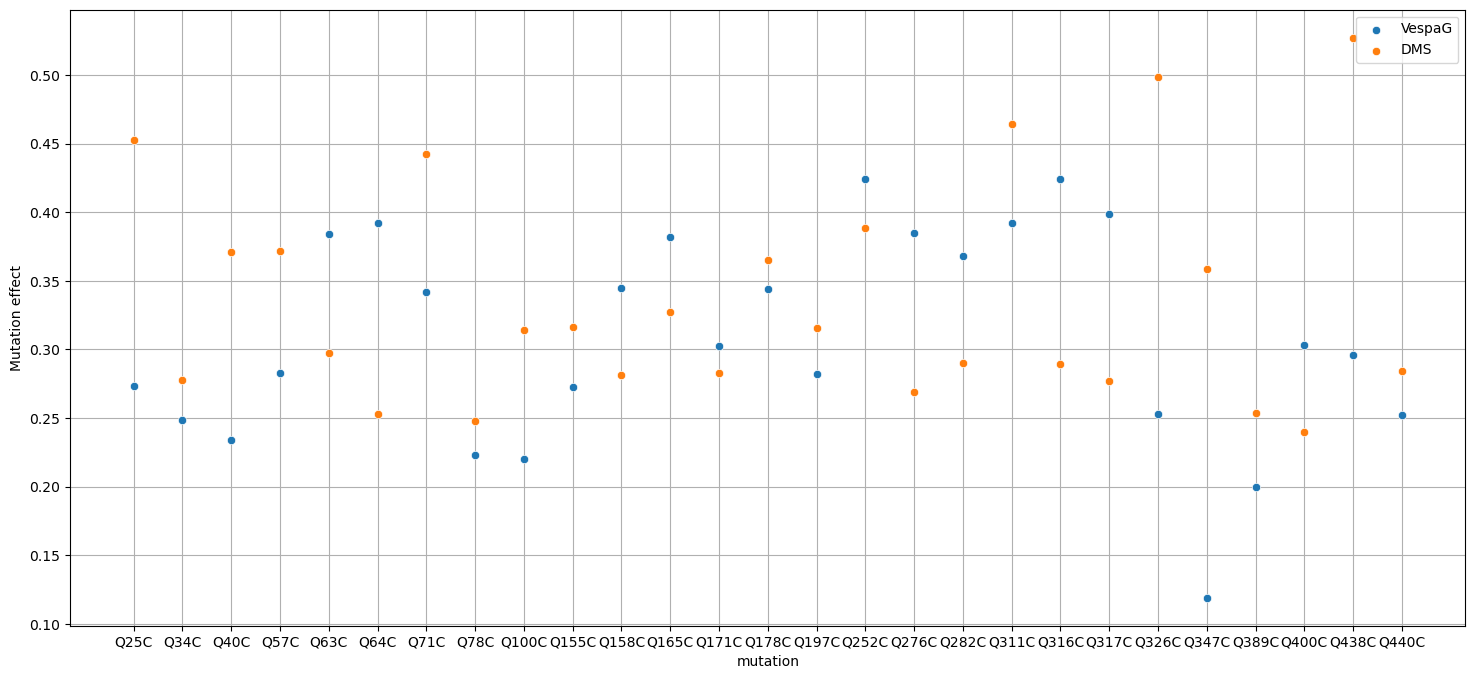

In [123]:
plt.figure(figsize=(18, 8))
sns.scatterplot(df.query('wildtype == "Q" and mutant == "C"'), x='mutation', y='mutation_effect_normalized', label='VespaG', zorder=2)
sns.scatterplot(df.query('wildtype == "Q" and mutant == "C"'), x='mutation', y='dms_mutation_effect_normalized', label='DMS', zorder=2)
plt.ylabel('Mutation effect')
plt.grid(zorder=0)
plt.legend()
plt.show()

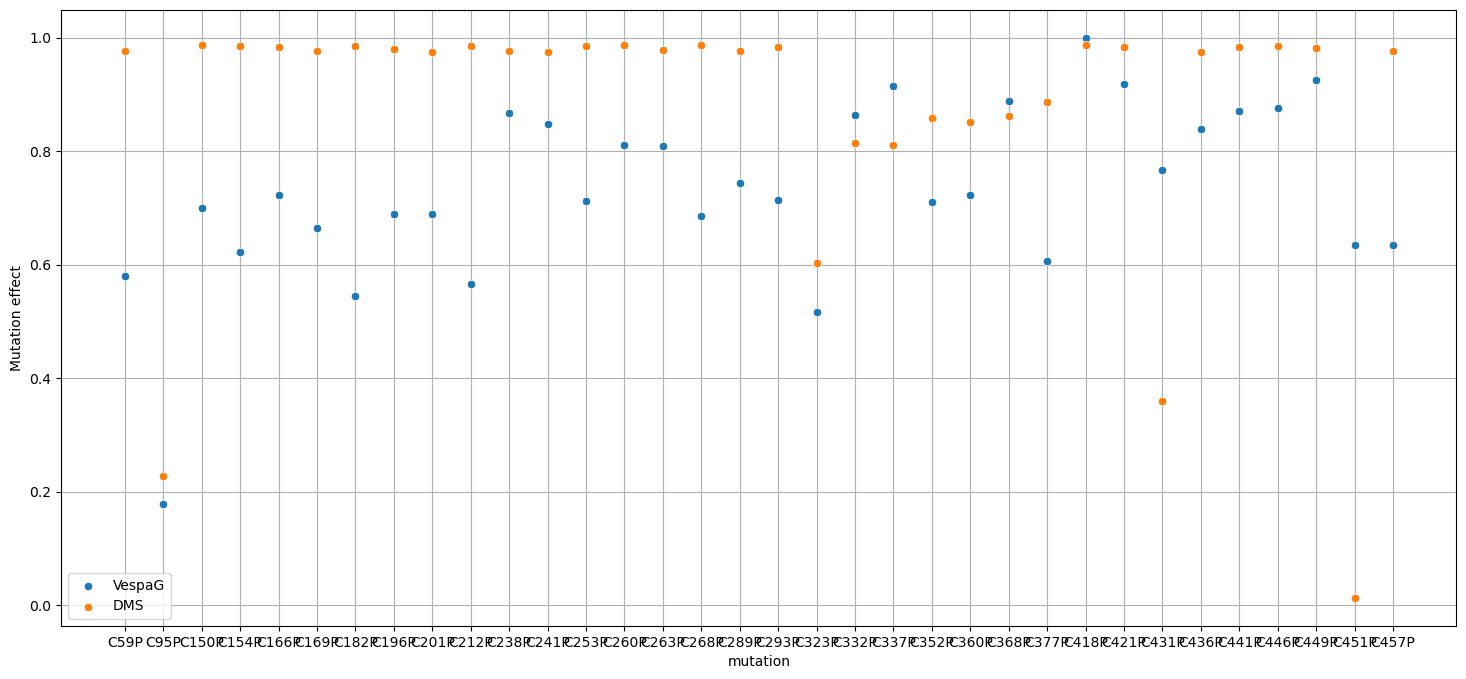

In [124]:
plt.figure(figsize=(18, 8))
sns.scatterplot(df.query('wildtype == "C" and mutant == "P"'), x='mutation', y='mutation_effect_normalized', label='VespaG', zorder=2)
sns.scatterplot(df.query('wildtype == "C" and mutant == "P"'), x='mutation', y='dms_mutation_effect_normalized', label='DMS', zorder=2)
plt.ylabel('Mutation effect')
plt.grid(zorder=0)
plt.legend()
plt.show()